# Symbolic Regression Tutorial
## Problem: Given input data and output data, find the functional form of the equation

### Explicit Training Data
The way that an acylic graph's fitness is evaluated is whether or not it models some training data correctly. When the output of the input data is known, explicit regression is the appropriate option for the EA algorithm. This requires having some valid `ExplicitTrainingData`. `ExplicitTrainingData` requires x and y input (represented as numpy arrays) as arguments.

In [16]:
import numpy as np

from bingo.SymbolicRegression.ExplicitRegression import ExplicitTrainingData

NUM_POINTS = 100
START = -10
STOP = 10

x = np.linspace(START, STOP, NUM_POINTS).reshape([-1, 1])
y = x**2 + 3.5*x**3
training_data = ExplicitTrainingData(x, y)

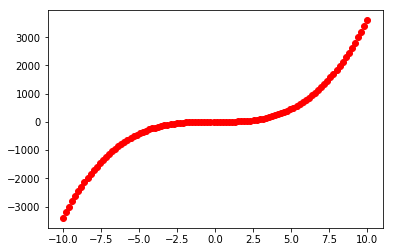

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig2, ax2 = plt.subplots()
ax2.plot(training_data.x, training_data.y, 'ro')

### AGraph Component Generator
Acyclic Graphs also require a component generator to generate the nodes that encompass an acylic graph object. The components necessary can be added by creating an instance of the `ComponentGenerator` object and inserting integer-based values for operations. 0 and 1 are default and load the variable and constant data, respectively. 2-12 add operators. See docs for more detail.

In [18]:
from bingo.SymbolicRegression.AGraph.ComponentGenerator import ComponentGenerator

ADD = 2
SUB = 3
MULT = 4

component_generator = ComponentGenerator(x.shape[1])
component_generator.add_operator(ADD)
component_generator.add_operator(SUB)
component_generator.add_operator(MULT)

### AGraph Variation
Set the the variation amongst the population per generation. Mutations will require the component generator in order to create new `AGraph`s.

In [19]:
from bingo.SymbolicRegression.AGraph.AGraphCrossover import AGraphCrossover
from bingo.SymbolicRegression.AGraph.AGraphMutation import AGraphMutation

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)

### Evaluation: Explicit Regression

The type of regression that will be used is `ExplicitRegression` since the training data has both input and output data to train against. `ExplicitRegression` extends `FitnessFunction`; hence, may be passed to `ContinuousLocalOptimization` object as an argument. This is then passed to an `Evaluation` object which will run `ExplicitRegression` on all `AGraph` individuals.

In [20]:
from bingo.SymbolicRegression.ExplicitRegression import ExplicitRegression
from bingo.Base.ContinuousLocalOptimization import ContinuousLocalOptimization
from bingo.Base.Evaluation import Evaluation

fitness = ExplicitRegression(training_data=training_data)
local_opt_fitness = ContinuousLocalOptimization(fitness, algorithm='lm')
evaluator = Evaluation(local_opt_fitness)

### AGraph Generator
The AGraph generator will use the component generator as before with the mutation class. This module generates `AGraph` individuals.

In [21]:
from bingo.SymbolicRegression.AGraph.AGraphGenerator import AGraphGenerator

STACK_SIZE = 10

agraph_generator = AGraphGenerator(STACK_SIZE, component_generator)

### Example AGraph

In [24]:
def output_f(training_data):
    x_0 = training_data.x
    dimension = x_0.shape[1]
    temp_str = ""
    for i in range(dimension):
        temp_str += "X_%s" % i
        if i != dimension - 1:
            temp_str += ', '
    return "f(" + temp_str + ") = "
            
    

In [25]:
np.random.seed(2)
agraph = agraph_generator()
agraph_pop = [agraph]
print(output_f(training_data), agraph_pop[0].get_latex_string())

f(X_0) =  X_0 + ? - (X_0) - (?) + X_0


f(X_0) =  X_0 + -6643.533785970885 - (X_0) - (-6643.533785970885) + X_0


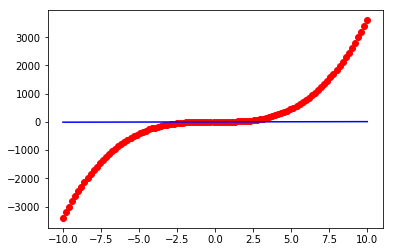

In [26]:
_, ax3 = plt.subplots()
evaluator(agraph_pop)
print(output_f(training_data), agraph_pop[0].get_latex_string())
ax3.plot(training_data.x, training_data.y, 'ro')
ax3.plot(training_data.x, agraph_pop[0].evaluate_equation_at(training_data.x), 'b')

### Age Fitness Evolutionary Algorithm

The algorithm used is `AgeFitnessEA`. This by default uses the `AgeFitnessSelection`. This also requires use of the `AGraphGenerator` in order to seed a random individual as to address the local minimization problem.

In [32]:
from bingo.Base.AgeFitnessEA import AgeFitnessEA
from bingo.Base.Island import Island

POPULATION_SIZE = 128
MUTATION_PROBABILITY = 0.4
CROSSOVER_PROBABILITY = 0.4

ea = AgeFitnessEA(evaluator, agraph_generator, crossover, mutation, MUTATION_PROBABILITY, CROSSOVER_PROBABILITY, POPULATION_SIZE)

np.random.seed(2)


island = Island(ea, agraph_generator, POPULATION_SIZE)

print(output_f(training_data), island.best_individual().get_latex_string())

f(X_0) =  ((X_0 + X_0)(X_0 + X_0))(X_0)


In [33]:
def animate_data(list_of_best_indv, training_data):

    fig, ax = plt.subplots()
    
    num_generations = len(list_of_best_indv)
    x = training_data.x
    y_actually = training_data.y
    y = list_of_best_indv
    plt.plot(training_data.x, training_data.y, 'ro')
    points, = ax.plot(x, y[0].evaluate_equation_at(x), 'b')
    points.set_label('Generation :' + str(0))
    legend = ax.legend(loc='upper right', shadow=True)


    def animate(i):
        ax.collections.clear()
        points.set_ydata(y[i].evaluate_equation_at(x))  # update the data
        points.set_label('Generation :' + str(i))
        legend = ax.legend(loc='upper right')
        return points, legend


    # Init only required for blitting to give a clean slate.
    def init():
        points.set_ydata(np.ma.array(x, mask=True))
        return points, points

    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.title("Best Individual in Island", fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    return animation.FuncAnimation(fig, animate, num_generations, init_func=init,
                                interval=250, blit=True)

### Simulation
Run until convergence. Print the best result. We store each best individual in a list and use this to observe how the best solution evolves over time.

In [34]:
ERROR_TOLERANCE = 1e-10

best_indv_values = []
best_indv_values.append(island.best_individual())

i = 1
while island.best_individual().fitness > ERROR_TOLERANCE:
    island.execute_generational_step()
    best_indv_values.append(island.best_individual())
    i += 1

print("Generation: ", i)
print("Success!", island.best_individual().get_latex_string())

Generation:  207
Success! ((3.5)(X_0) + 1.0000000000000016)((X_0)(X_0))


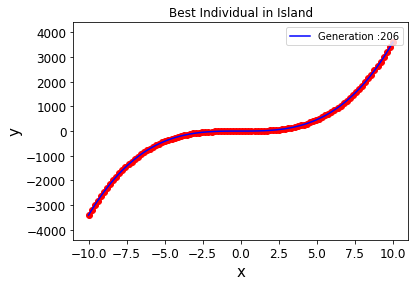

In [36]:
from IPython.display import HTML

anim2 = animate_data(best_indv_values, training_data)
HTML(anim2.to_html5_video())